In [476]:
from pathos.multiprocessing import ProcessPool
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from itertools import product

In [477]:
N_0 = 2
h = 0.00000032
m = 48
T = 1
L = 1
sigma = 3.405 #Armstrong
epsilon = 119.8 #K

p = 0.4
v = 0
r_0 = np.array([[-p,0,0],[p,0,0]]) #np.random.uniform(-L/2, L/2, (N_0, 3)) #randomly between 0 and L with gaussian distribution, mean 0, std sqrt(kT^*/m^*), m^* = 48, k = 1, are the velocities normally distributed in every seperate direction?
v_0 = np.array([[0,0,0],[0,0,0]]) #np.random.normal(0,np.sqrt(T/48), (N_0, 3))

"""
r_0: Initial positions of the system
    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle
v_0: Initial velocities of the system particles
    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle
"""

# Generate all combinations of zeros and ones for a 3-dimensional list
list_pbc = list(product([0, 1, -1], repeat=3))
list_pbc = np.array(list_pbc)

def f(r_i, r_j):
    index_min = np.argmin([np.sum([(r_i[d]-r_j[d]+vec_L[d])**2 for d in range(2)]) for vec_L in list_pbc])
    vec_L_min = list_pbc[index_min]
    r_ij = np.sqrt(np.sum([(r_i[d]-r_j[d]+vec_L_min[d])**2 for d in range(2)]))
    f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_z = m*(r_i[2]-r_j[2]+vec_L_min[2])*(r_ij**(-14)+0.5*r_ij**(-8))
    return np.array([f_x, f_y, f_z])

def arange_without(i):
    original_array = np.arange(N_0)
    result_array = original_array[original_array != i]
    return result_array

def F(r):
    return np.array([np.sum(np.array([f(r[i], r[k]) for k in arange_without(i)]), axis=0) for i in range(r.shape[0])])
    #return [f(r[i], r[k]) for k in arange_without(i)] pool.map()
    #pool = ProcessPool(nodes=4)
    #results = pool.map(f_subprocess, (r for i in range(r.shape[0])), range(r.shape[0]))
    #return np.array(results)

def verlet_step(r, v):
    v_tilde = v + h/(2*m)*F(r)
    r_next = r + h*v_tilde
    f_next = F(r_next)
    v_next = v_tilde + (h/(2*m))*f_next
    return r_next, v_next

def verlet_algorithm(r_0, v_0, num_steps):
    list_r = [r_0]
    list_v = [v_0]
    for t in tqdm(range(num_steps)):
        r_new, v_new = verlet_step(list_r[-1], list_v[-1])
        list_r.append(r_new)
        list_v.append(v_new)
    return np.array(list_r), np.array(list_v)

def Temperature(v):
    return 16*np.mean([(v_i[0]**2)+(v_i[1]**2)+(v_i[2]**2) for v_i in v])

Text(0.5, 0.92, 'Initial state of the Argon ')

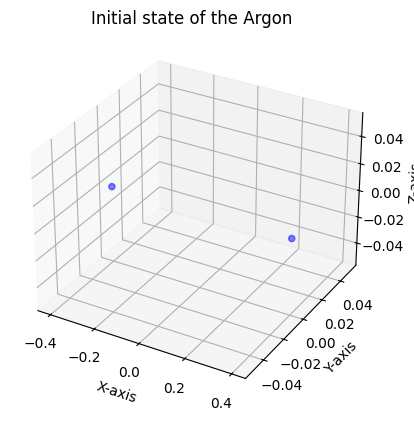

In [478]:
#Seeing how the initial state looks like
#ax = plt.figure().add_subplot(projection='3d')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Extract x, y, and z coordinates
x = r_0[:,0].flatten()
y = r_0[:,1].flatten()
z = r_0[:,2].flatten()

# Plot the points
ax.scatter(x, y, z, c='b', marker='o', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the title
ax.set_title('Initial state of the Argon ')

# Show the plot
#plt.show()

In [479]:
t_max = 1000
r_total, v_total = verlet_algorithm(r_0, v_0, t_max)

100%|██████████| 1000/1000 [00:00<00:00, 1625.88it/s]


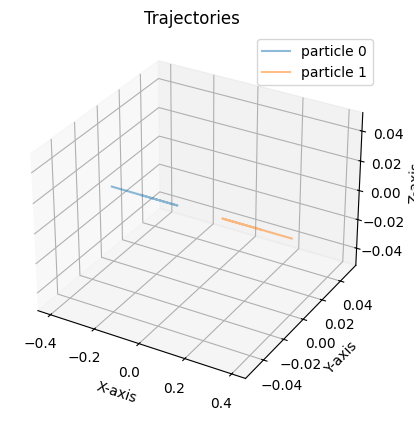

In [484]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(r_total[:,0,0], r_total[:,0,1], r_total[:,0,2], alpha=0.5, label= "particle 0")
ax.plot(r_total[:,1,0], r_total[:,1,1], r_total[:,1,2], alpha=0.5, label= "particle 1")


ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectories ')
plt.legend()

Text(0.5, 1.0, 'Temperature over time')

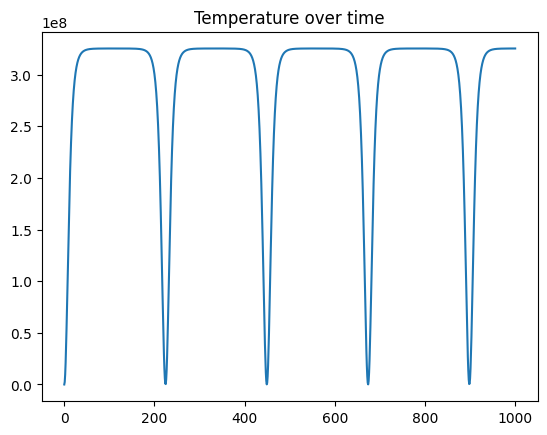

In [489]:
T_total = [Temperature(v_t) for v_t in v_total]
plt.plot(np.arange(t_max+1), T_total)
plt.title("Temperature over time")

Text(0.5, 1.0, 'Force that acts on particle 0 in x-direction over time')

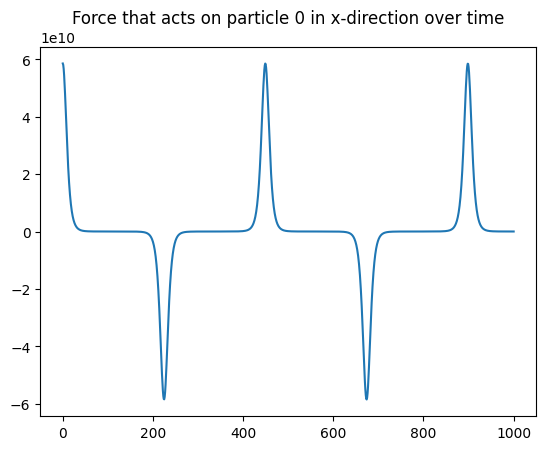

In [491]:
plt.plot(np.arange(t_max+1), [F(r_total[t])[0,0] for t in range(t_max+1)])
plt.title("Force that acts on particle 0 in x-direction over time")